In [ ]:
from google.colab import userdata
import pandas as pd
from io import StringIO
import pathlib
import textwrap
import google.generativeai as genai
from IPython.display import display
from IPython.display import Markdown

def to_markdown(text):
    text = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))
mykey = userdata.get('GeminiKey')
genai.configure(api_key=mykey)

# Chain of Thought Prompt

In [ ]:
gemini_prompt = """
You are tasked with generating 100 synthetic data points for this dataset while ensuring fairness and adherence to specific column constraints. Follow each step carefully to ensure that the generated data maintains statistical significance and has no bias.
My instructions:please only include data, not python code. Well formatting the data to a csv file, which is coma separated

Order ID:
Unique Count: 5000+ unique order IDs.
Most Common Order ID occurs fewer than 5 times.
Think: Order IDs should be unique to transactions but may repeat for multi-line orders.
Generate unique IDs with occasional repetitions reflecting realistic transaction scenarios.
Please follow random distribution, which means orderId follow this pattern
These are few examples: CA-2016-152156, CA-2017-120999

Order Date:
Range: From 2015-01-01 to 2021-12-31.
Average Orders Per Day: ~15.
Think: Order dates should reflect seasonality and peak shopping periods (e.g., holidays).
Generate dates with a realistic temporal pattern, ensuring seasonality.

Ship Date:
Range: Order Date + 1 to 10 days.
Shipping Duration: Mean: 4 days, Median: 3 days, Standard Deviation: 1.5 days.
Think: Ship dates should follow order dates closely and reflect different shipping speeds.
Generate shipping durations with a normal distribution and realistic delays.

Ship Mode:
Modes: 'Standard Class' (60%), 'Second Class' (25%), 'First Class' (10%), 'Same Day' (5%).
Think: Ship modes depend on customer urgency and distance to destination.
Generate modes with a weighted distribution reflecting urgency.

Customer ID:
Unique Count: 4000+ unique customers.
Most Common Customer ID occurs fewer than 10 times.
Think: Customer IDs should reflect repeat purchases but mostly unique customers.
Generate IDs with occasional repeats to reflect loyal customers.
Customer Name:

Unique Count: Matches Customer ID count.
Think: Each Customer ID should have a unique corresponding Customer Name.
Generate names with diversity, ensuring alignment with Customer IDs.
Segment:

Categories: 'Consumer' (50%), 'Corporate' (30%), 'Home Office' (20%).
Think: Segment distribution reflects customer types and business demand.
Generate segments with a proportional distribution matching the original data.
Country:

Values: Always "United States."
Think: This dataset focuses solely on US transactions.
Generate "United States" for all rows.
City:

Unique Count: ~500 cities.
Most Common City: Appears ~50 times.
Think: Cities should align with State and Region distribution.
Generate cities with realistic geographic frequency. Mainly in US, also make sure this column related to state and region to make generated data meaningful.

State:
Unique Count: 49 states (excluding territories).
Most Common State: Appears ~200 times.
Think: States should align with City and Region values.
Generate states with proportional representation, ensuring alignment with regions.

Postal Code:
This field is an integer.
Unique Count: Matches city count.
Think: Postal codes should match the cities and states they represent.
Generate postal codes with realistic mapping to City and State.
Region:

Categories: 'West,' 'East,' 'Central,' 'South.'
Think: Regions should align with State and City distributions.
Generate regions with proportional representation across states and cities.
Category:

Categories: 'Furniture,' 'Office Supplies,' 'Technology.'
Think: Categories should reflect demand trends and balance.
Generate categories with a realistic proportional split.
Sub-Category:

Unique Count: ~20 sub-categories.
Think: Sub-categories should align with Category (e.g., 'Chairs' under 'Furniture').
Generate sub-categories ensuring alignment with categories.
Product Name:

Unique Count: 1850 products.
Most Common Product: Appears 48 times.
Think: Products should align with Sub-Category.
Generate products with realistic frequency and alignment to sub-categories.
Sales:

Mean: $229.86, Standard Deviation: $623.25, Range: $0.44 to $22,638.48.
Think: Sales should correlate with Quantity, Discount, and Product Price.
Generate sales values reflecting realistic pricing tiers.
Quantity:

Range: 1 to 14.
Mean: 3.79, Median: 3.
Think: Quantity should align with product type and sales value.
Generate quantities balancing bulk and single-unit purchases.
Discount:

Range: 0 to 0.8 (frequent: 0.0, 0.2).
Mean: 0.156, Median: 0.2.
Think: Discounts should depend on sales strategies and product categories.
Generate discounts with realistic values and frequent promotional rates.
Profit:

Range: -$6,599.98 to $8,399.98.
Mean: $28.66, Standard Deviation: $234.26.
Think: Profit depends on Sales, Quantity, and Discount.
Generate profit values reflecting occasional losses and high profits.
Shipping Duration (Derived):

Mean: 4 days, Median: 3 days.
Think: Duration should depend on Ship Mode and distance (Region).
Generate durations aligned with shipping and geographic context.
This chain-of-thought prompt ensures that the relationships between columns (e.g., City-State-Region, Sales-Quantity-Discount-Profit) are maintained while preserving the statistical significance and balance observed in the original dataset. You can use this directly for generating synthetic data.

This is the data you should generate:
CA-2016-152156	2016/1/5	2016/1/9	Standard Class	CG-12520	Claire Gute	Consumer	United States	New York City	New York	10001	East	Furniture	Bookcases	Bush	261.96	2	0	41.96	4

This is the column you should generate:
	Order ID	Order Date	Ship Date	Ship Mode	Customer ID	Customer Name	Segment	Country	City	State	Postal Code	Region	Category	Sub-Category	Product Name	Sales	Quantity	Discount	Profit	Shipping Duration


Do not stop generating untill the you generate 100 data points. Also, please DO NOT include any message other than the data points.
I DONT WANT ANYTHING LIKE THIS: ... (rest of the ** data points)
I ONLY ONLY ONLY WANT DATA.
If you can only provide me with data, I will reward you with a gold medal
"""

# Model Configuration

In [ ]:
model = genai.GenerativeModel("gemini-1.5-flash-8b",system_instruction="You are a Sythetic Data Generator, you will continueously generating data untill reach the limit")

In [ ]:
config = genai.GenerationConfig(
    max_output_tokens=5000,  # Increase if more tokens are allowed
    temperature=0.7,         # Keep low for coherent data
    top_p=1,
    top_k=40                  # Setting to 0 means no restriction on token
)

# Generation Data Using batch

In [ ]:
# Initialize an empty DataFrame to store the generated data
data = pd.DataFrame()

while len(data) < 100:
    response = model.generate_content(gemini_prompt, generation_config=config)
    generated_data = response.text
    try:
        temp_data = pd.read_csv(StringIO(generated_data))
        data = pd.concat([data, temp_data], ignore_index=True)

        if len(data) > 100:
            data = data.iloc[:100]

    except pd.errors.ParserError:
        print("Error parsing generated data, skipping iteration.")

# Save the final data to CSV
data.to_csv("heart_disease_data_gemini_generated.csv", index=False)

In [ ]:
from google.colab import files
data = data.dropna()
data.to_csv("gemini_generated_data_supterstore.csv")
files.download("gemini_generated_data_supterstore.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1)	Kolmogorov-Smirnov Test and Wasserstein Distance for Numerical Variables

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, chisquare, energy_distance
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
synthetic_df = pd.read_csv('/content/drive/MyDrive/SDGDATA/gemini_generated_data_supterstore (3).csv')
superstore_df = pd.read_csv('/content/drive/MyDrive/SDGDATA/Sample - Superstore.csv',encoding='latin1')

synthetic_df.columns

Index(['Unnamed: 0', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Category', 'Sub-Category', 'Product Name',
       'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Duration'],
      dtype='object')

In [ ]:
superstore_df.drop(columns = ['Product ID'], inplace=True)

In [ ]:
synthetic_df.drop(columns = ['Unnamed: 0'], inplace=True)
superstore_df.drop(columns = ['Row ID'], inplace=True)

In [ ]:
synthetic_df.columns

Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Category', 'Sub-Category', 'Product Name', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Shipping Duration'],
      dtype='object')

In [ ]:
superstore_df.columns

Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name',
       'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [ ]:
original_processed.columns

Index(['Order ID', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment',
       'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID',
       'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity',
       'Discount', 'Profit', 'Order Date_Year', 'Order Date_Month',
       'Order Date_Day', 'Ship Date_Year', 'Ship Date_Month', 'Ship Date_Day'],
      dtype='object')

In [ ]:
numerical_cols = ['Sales', 'Quantity', 'Discount', 'Profit']
categorical_cols = ['Ship Mode', 'Segment', 'State', 'Region', 'Category', 'Sub-Category']
datetime_cols = ['Order Date', 'Ship Date']

# Preprocessing: Encode categorical variables and handle datetime
def preprocess_data(df):
    df_processed = df.copy()
    le_dict = {}

    # Handle datetime columns - convert to numerical features
    for date_col in datetime_cols:
        if date_col in df_processed.columns:
            # Convert to datetime if not already
            df_processed[date_col] = pd.to_datetime(df_processed[date_col],)
            # Extract useful features from datetime
            df_processed[f'{date_col}_Year'] = df_processed[date_col].dt.year
            df_processed[f'{date_col}_Month'] = df_processed[date_col].dt.month
            df_processed[f'{date_col}_Day'] = df_processed[date_col].dt.day
            # Drop original datetime column
            df_processed = df_processed.drop(columns=[date_col])

    # Encode categorical variables
    for col in df_processed.columns:
        if df_processed[col].dtype == 'object' or df_processed[col].dtype == 'bool':
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
            le_dict[col] = le

    return df_processed, le_dict

# Process the data
original_processed, le_dict_original = preprocess_data(superstore_df)
synthetic_processed, le_dict_synthetic = preprocess_data(synthetic_df)


<ipython-input-113-14fb7ae1fb1b>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
<ipython-input-113-14fb7ae1fb1b>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_df[col], label='Synthetic', shade=True)


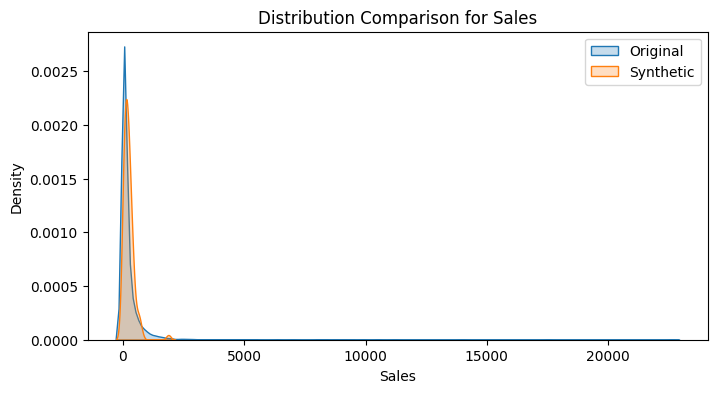

<ipython-input-113-14fb7ae1fb1b>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
<ipython-input-113-14fb7ae1fb1b>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_df[col], label='Synthetic', shade=True)


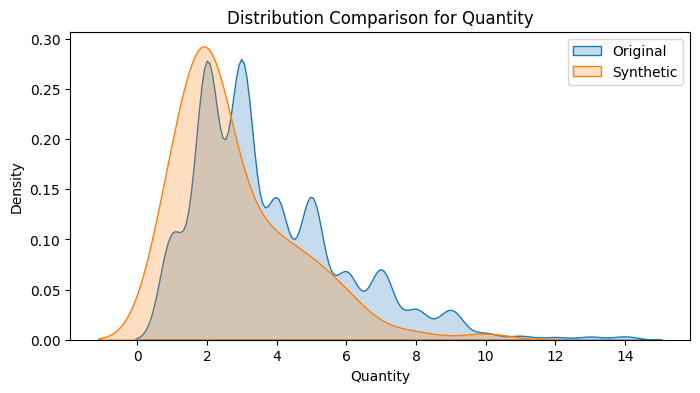

<ipython-input-113-14fb7ae1fb1b>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
<ipython-input-113-14fb7ae1fb1b>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_df[col], label='Synthetic', shade=True)


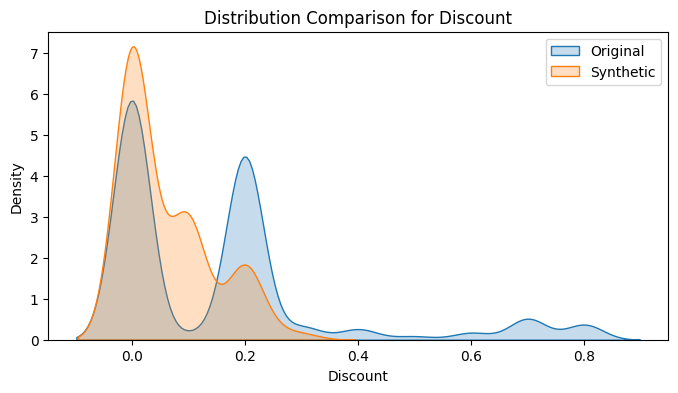

<ipython-input-113-14fb7ae1fb1b>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
<ipython-input-113-14fb7ae1fb1b>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_df[col], label='Synthetic', shade=True)


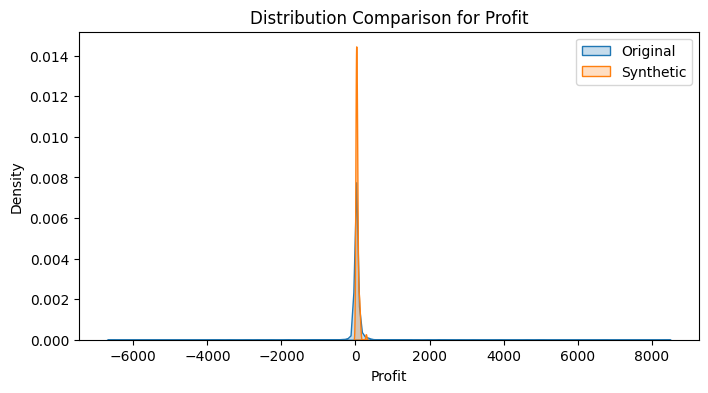

     Column  KS Statistic    KS p-value  Wasserstein Distance
0     Sales      0.377524  1.976397e-12            136.299118
1  Quantity      0.265447  2.784951e-06              0.981063
2  Discount      0.345729  1.910081e-10              0.096096
3    Profit      0.356020  4.570453e-11             45.810623


In [ ]:
def compare_numerical_distributions(original_df, synthetic_df, columns):
    distribution_metrics = []
    for col in columns:
        ks_stat, ks_p_value = ks_2samp(original_df[col], synthetic_df[col])
        wd = wasserstein_distance(original_df[col], synthetic_df[col])
        distribution_metrics.append({
            'Column': col,
            'KS Statistic': ks_stat,
            'KS p-value': ks_p_value,
            'Wasserstein Distance': wd
        })
        # Plot distributions
        plt.figure(figsize=(8, 4))
        sns.kdeplot(original_df[col], label='Original', shade=True)
        sns.kdeplot(synthetic_df[col], label='Synthetic', shade=True)
        plt.title(f'Distribution Comparison for {col}')
        plt.legend()
        plt.show()
    return pd.DataFrame(distribution_metrics)

numerical_distribution_metrics = compare_numerical_distributions(
    original_processed, synthetic_processed, numerical_cols)
print(numerical_distribution_metrics)


TRAIN ON SYNTHETIC, TEST ON ORIGINAL Evaluation:
Mean Squared Error: 50372.99
Root Mean Squared Error: 224.44
Mean Absolute Error: 54.56
R² Score: 0.06

TRAIN ON ORIGINAL, TEST ON SYNTHETIC Evaluation:
Mean Squared Error: 1966.90
Root Mean Squared Error: 44.35
Mean Absolute Error: 25.71
R² Score: -0.34


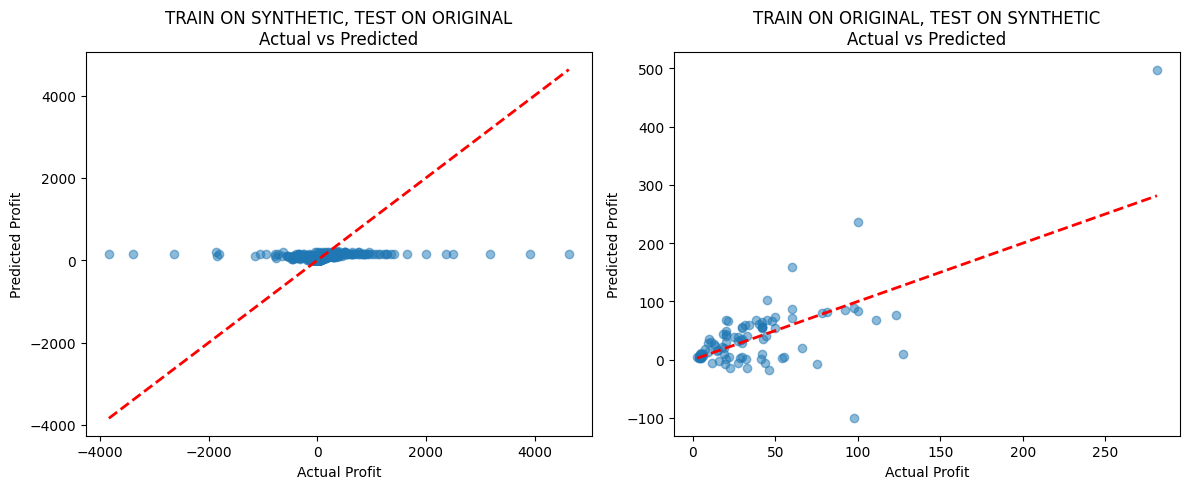

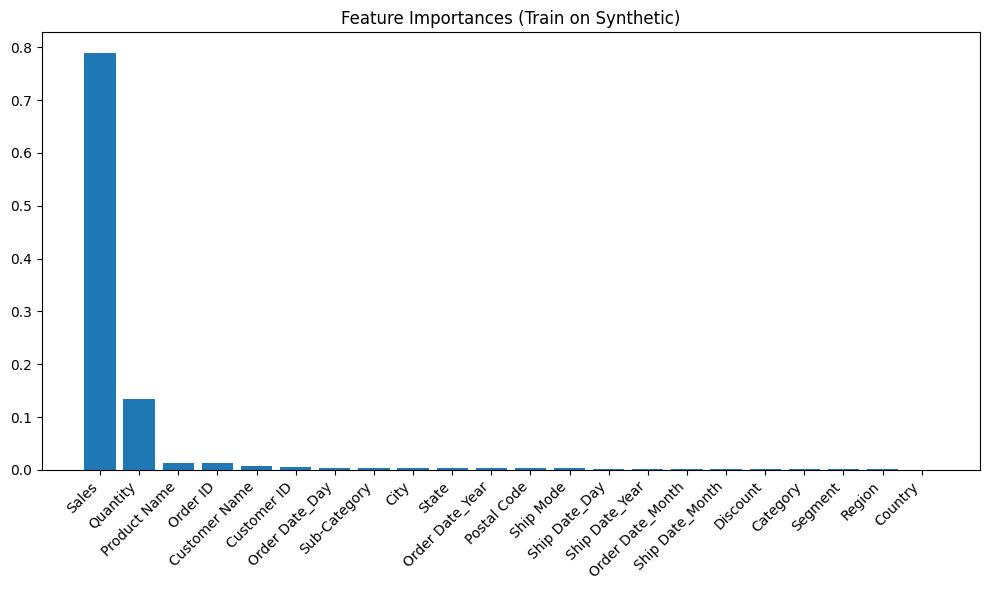

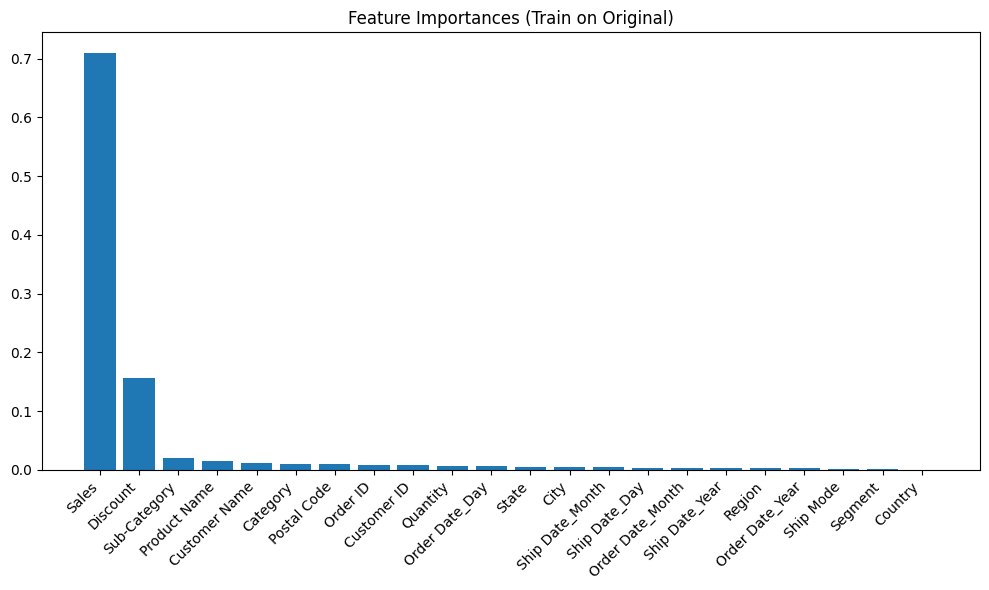

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Define target and features
target_column = 'Profit'
feature_columns = [col for col in original_processed.columns if col != target_column]

# Split the original data
X_orig = original_processed[feature_columns]
y_orig = original_processed[target_column]
X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(
    X_orig, y_orig, test_size=0.3, random_state=42)

# Prepare synthetic data
X_synth = synthetic_processed[feature_columns]
y_synth = synthetic_processed[target_column]

# TSTR: Train on Synthetic, Test on Original
model_tstr = RandomForestRegressor(n_estimators=100, random_state=42)
model_tstr.fit(X_synth, y_synth)
y_pred_tstr = model_tstr.predict(X_orig_test)

# TSOR: Train on Original, Test on Synthetic
model_tsor = RandomForestRegressor(n_estimators=100, random_state=42)
model_tsor.fit(X_orig_train, y_orig_train)
y_pred_tsor = model_tsor.predict(X_synth)

# Evaluate models
def evaluate_regression(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Evaluation:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R² Score: {r2:.2f}")

# Print evaluation metrics
evaluate_regression(y_orig_test, y_pred_tstr, "TRAIN ON SYNTHETIC, TEST ON ORIGINAL")
evaluate_regression(y_synth, y_pred_tsor, "TRAIN ON ORIGINAL, TEST ON SYNTHETIC")

# Plot actual vs predicted values
plt.figure(figsize=(12, 5))

# TSTR Scatter Plot
plt.subplot(1, 2, 1)
plt.scatter(y_orig_test, y_pred_tstr, alpha=0.5)
plt.plot([y_orig_test.min(), y_orig_test.max()], [y_orig_test.min(), y_orig_test.max()], 'r--', lw=2)
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.title('TRAIN ON SYNTHETIC, TEST ON ORIGINAL\nActual vs Predicted')

# TSOR Scatter Plot
plt.subplot(1, 2, 2)
plt.scatter(y_synth, y_pred_tsor, alpha=0.5)
plt.plot([y_synth.min(), y_synth.max()], [y_synth.min(), y_synth.max()], 'r--', lw=2)
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.title('TRAIN ON ORIGINAL, TEST ON SYNTHETIC\nActual vs Predicted')

plt.tight_layout()
plt.show()

# Feature importance plot
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances ({title})")
    plt.bar(range(X_orig.shape[1]), importances[indices])
    plt.xticks(range(X_orig.shape[1]), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot feature importance for both models
plot_feature_importance(model_tstr, feature_columns, "Train on Synthetic")
plot_feature_importance(model_tsor, feature_columns, "Train on Original")


## 3) Distribution Comparison using Divergence measures

KL Divergence for Ship Mode: 13.250865278040264
KL Divergence for Segment: 0.002505338362555329
KL Divergence for State: 11.55536171582908
KL Divergence for Region: 0.16871069481182405
KL Divergence for Category: 0.10250325578990682
KL Divergence for Sub-Category: 0.8941066147214124


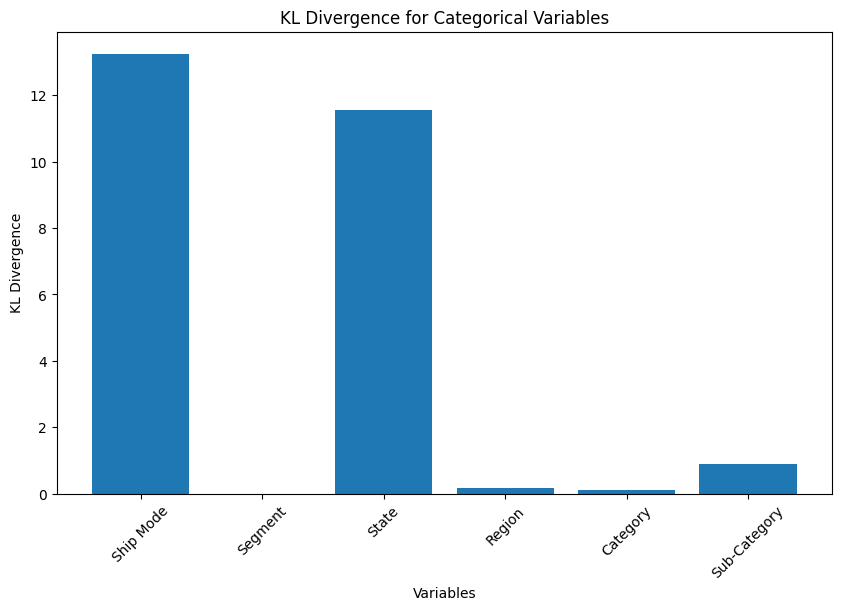

In [ ]:
def compute_kl_divergence(p, q):
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    return np.sum(p * np.log(p / q))

kl_divergences = {}

for col in categorical_cols:
    orig_counts = original_processed[col].value_counts(normalize=True).sort_index()
    synth_counts = synthetic_processed[col].value_counts(normalize=True).sort_index()
    all_categories = orig_counts.index.union(synth_counts.index)
    p = orig_counts.reindex(all_categories, fill_value=0).values
    q = synth_counts.reindex(all_categories, fill_value=0).values
    kl_div = compute_kl_divergence(p, q)
    kl_divergences[col] = kl_div
    print(f"KL Divergence for {col}: {kl_div}")

# Plot KL Divergences
plt.figure(figsize=(10, 6))
plt.bar(kl_divergences.keys(), kl_divergences.values())
plt.title('KL Divergence for Categorical Variables')
plt.xlabel('Variables')
plt.ylabel('KL Divergence')
plt.xticks(rotation=45)
plt.show()


## 4) Coverage and Density Measure

In [ ]:
numerical_features = numerical_cols

X_orig_num = original_processed[numerical_features].values
X_synth_num = synthetic_processed[numerical_features].values

def compute_coverage(X_train, X_synth, threshold=0.7):
    nbrs = NearestNeighbors(n_neighbors=1).fit(X_synth)
    distances, _ = nbrs.kneighbors(X_train)
    coverage = np.mean(distances <= threshold)
    return coverage

coverage_value = compute_coverage(X_orig_num, X_synth_num)
print(f"Coverage of synthetic data over original data: {coverage_value * 100:.2f}%")

Coverage of synthetic data over original data: 0.40%


## 5) Correlation and Relationship Analysis

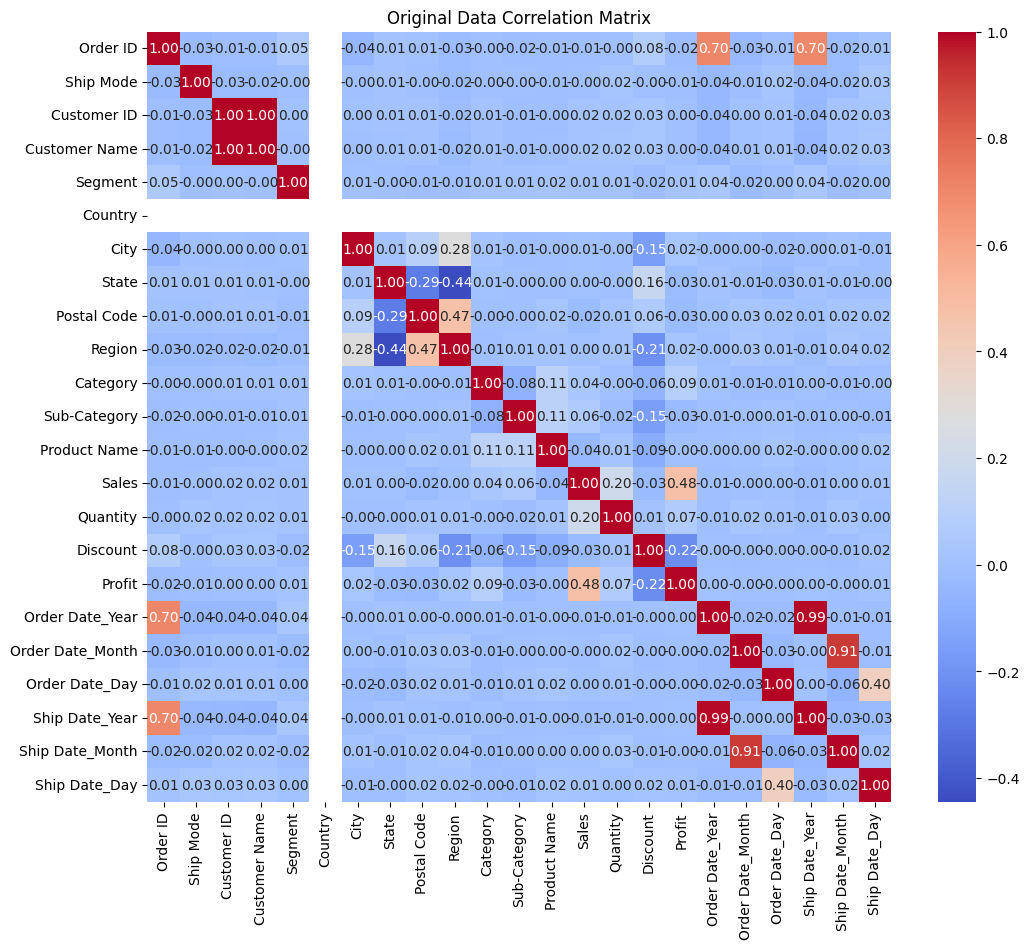

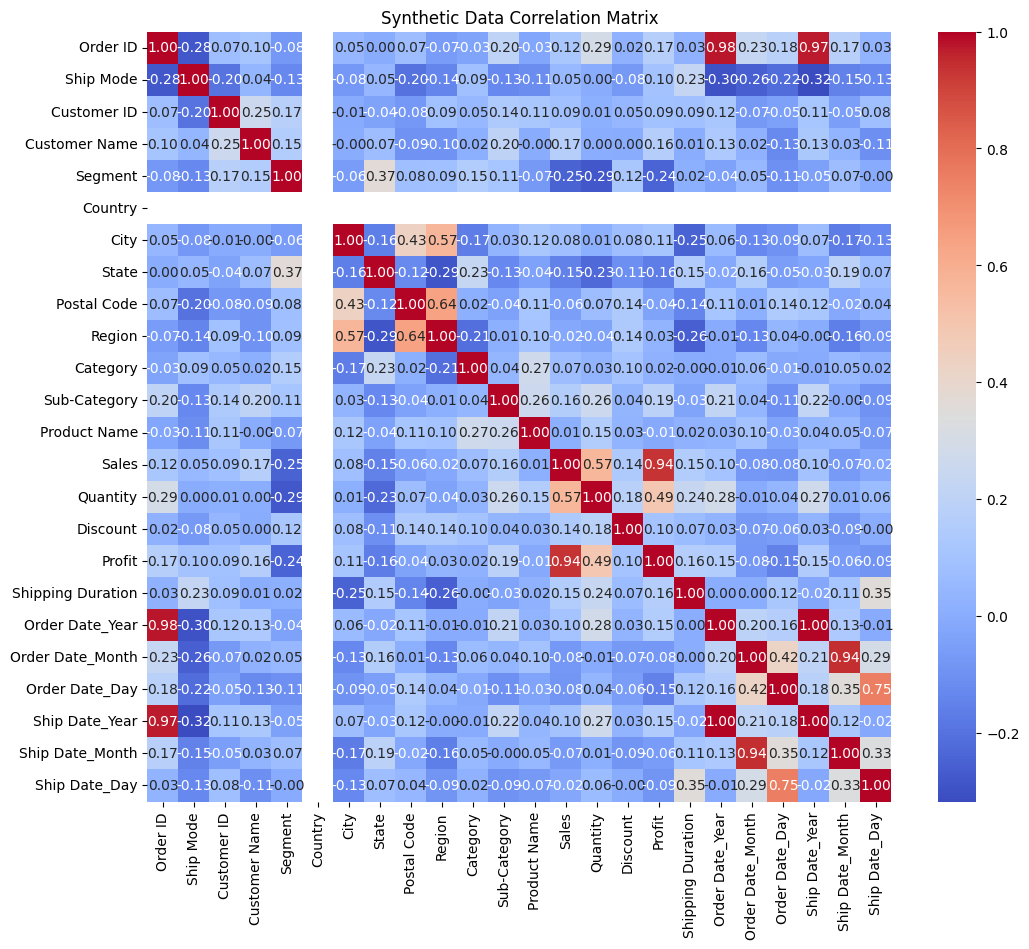

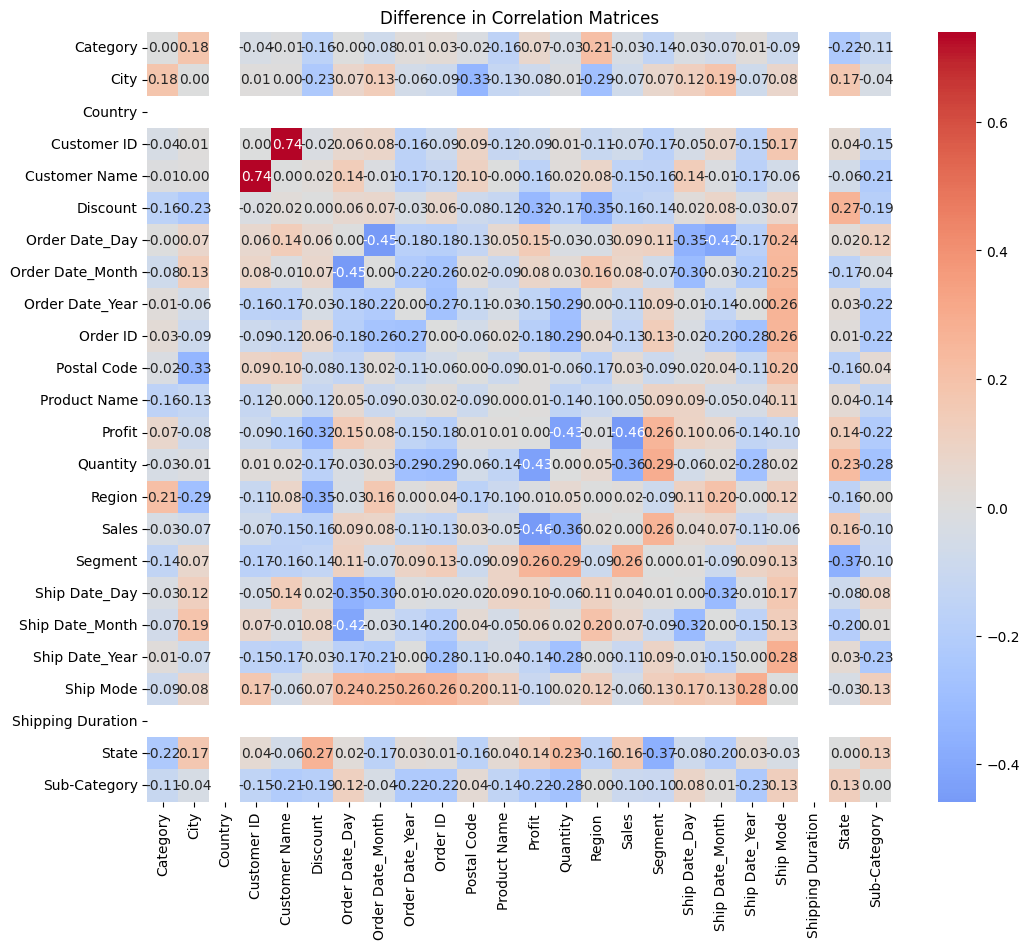

In [ ]:
corr_original = original_processed.corr()
corr_synthetic = synthetic_processed.corr()
# Difference between the correlation matrices
corr_diff = corr_original - corr_synthetic
# Visualize the original correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_original, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Original Data Correlation Matrix')
plt.show()
# Visualize the synthetic correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_synthetic, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Synthetic Data Correlation Matrix')
plt.show()
# Visualize the difference
plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Difference in Correlation Matrices')
plt.show()

## 6) Synthetic Data Utility Score (SDUS)

Synthetic Data Utility Score (SDUS): 0.0


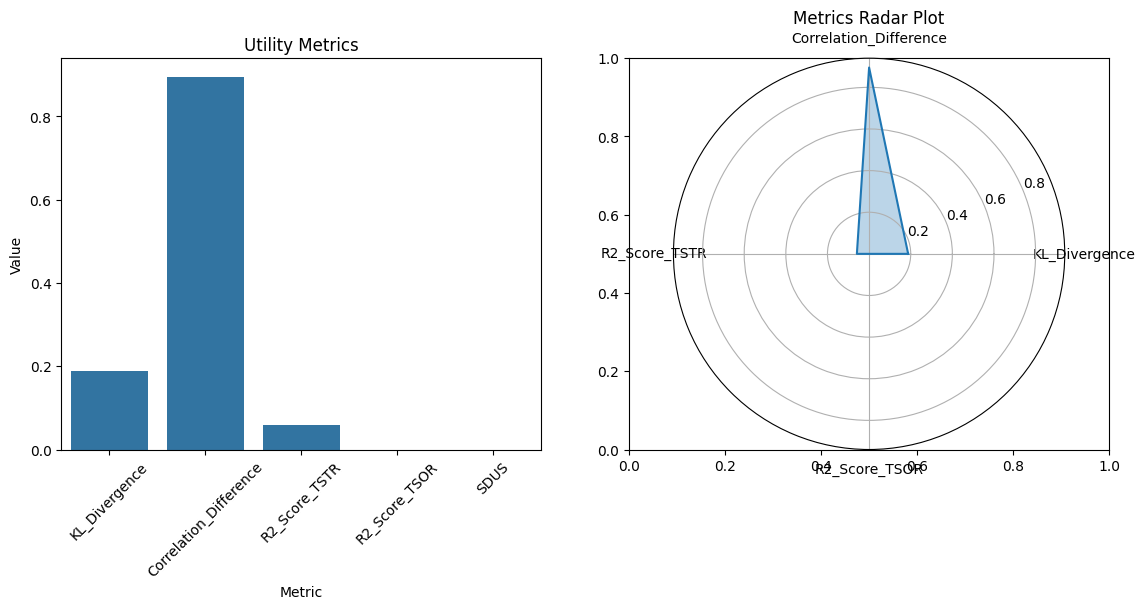


Detailed Metrics:
KL_Divergence: 0.1877
Correlation_Difference: 0.8952
R2_Score_TSTR: 0.0587
R2_Score_TSOR: 0.0000


In [ ]:
# Collect metrics
metrics_df = pd.DataFrame({
    'KL_Divergence': [np.mean(list(kl_divergences.values()))],
    'Correlation_Difference': [corr_diff.abs().mean().mean()],  # Mean absolute difference
    'R2_Score_TSTR': [r2_score(y_orig_test, y_pred_tstr)],
    'R2_Score_TSOR': [r2_score(y_synth, y_pred_tsor)]
})

# Normalize metrics (assuming higher is better for R2 scores)
metrics_df['KL_Divergence'] = 1 / (1 + metrics_df['KL_Divergence'])
metrics_df['Correlation_Difference'] = 1 / (1 + metrics_df['Correlation_Difference'])
# R2 scores are already normalized between -∞ and 1, but let's clip negative values
metrics_df['R2_Score_TSTR'] = np.clip(metrics_df['R2_Score_TSTR'], 0, 1)
metrics_df['R2_Score_TSOR'] = np.clip(metrics_df['R2_Score_TSOR'], 0, 1)

# Combine metrics
metrics_normalized = MinMaxScaler().fit_transform(metrics_df)
sdus = metrics_normalized.mean(axis=1)[0]
print(f"Synthetic Data Utility Score (SDUS): {sdus}")

# Plot the utility metrics
metrics_df_plot = metrics_df.copy()
metrics_df_plot['SDUS'] = sdus

# Create a more detailed visualization
plt.figure(figsize=(12, 6))

# Bar plot
plt.subplot(1, 2, 1)
metrics_df_plot_melted = metrics_df_plot.melt(var_name='Metric', value_name='Value')
sns.barplot(data=metrics_df_plot_melted, x='Metric', y='Value')
plt.title('Utility Metrics')
plt.xticks(rotation=45)

# Radar plot
plt.subplot(1, 2, 2)
categories = list(metrics_df.columns)
values = metrics_df.iloc[0].values

# Calculate angle for each axis
angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
angles += angles[:1]

# Add the first value to close the polygon
values = np.concatenate((values, [values[0]]))

# Plot
ax = plt.subplot(1, 2, 2, projection='polar')
ax.plot(angles, values)
ax.fill(angles, values, alpha=0.3)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title('Metrics Radar Plot')

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Metrics:")
for column in metrics_df.columns:
    print(f"{column}: {metrics_df[column].values[0]:.4f}")